In [144]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [145]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

cols = ['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality',
       'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [130]:
from implementations import *

In [146]:
## Preprocessing

def one_hot_jet_num(tX):
    #move jet_num to the last position
    tX.T[[22, -1]] = tX.T[[-1, 22]]
    
    #extract the jet_num column
    one_hot = tX[:,-1].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot


"""
# remove the rows containing at least 1 NaN
idx_with_nan = set([x[0] for x in np.argwhere(tX==-999)])

tX_nonan = tX[list(set(range(len(tX)))-idx_with_nan)]
y_nonan  = y[list(set(range(len(tX)))-idx_with_nan)]

tX_fullnan = tX[list(idx_with_nan)]
y_fullnan  = y[list(idx_with_nan)]

# len(tX_nonan) -> 68'114
# len(tX_fullnan) -> 181'886 over 250'000
"""
1

1

In [147]:
tX_hot = one_hot_jet_num(tX).copy()

In [122]:
#def least_squares_GD(y, tx, initial_w, max_iters, gamma)
    
#def least_squares_SGD(y, tx, initial_w, max_iters, gamma)
    
#def least_squares(y,tx)

#def ridge_regression(y, tx, lambda_)
    
#def logistic_regression(y, tx, initial_w, max_iters, gamma):
    
#def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):

In [149]:
print(tX_hot.shape[1])

33


In [150]:
seed = 263
degrees = [1,2]
k_fold = 4
lambdas = np.linspace(0, 1, 20)

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
ws = []

# cross validation
for degree in degrees:
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr_k, loss_te_k, w = cross_validation(y, tX_hot, k_indices, k, lambda_, degree)

            rmse_tr_tmp.append(loss_tr_k)
            rmse_te_tmp.append(loss_te_k)
        ws.append(w)
        #combine the loss over the folds
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

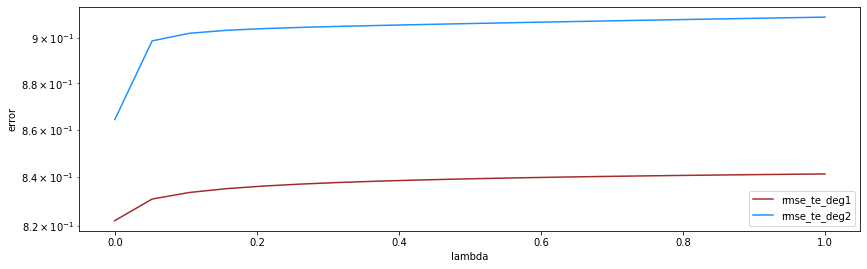

In [151]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
#ax1.plot(lambdas, rmse_tr[:30], 'magenta', label="rmse_tr_deg1")
ax1.plot(lambdas, rmse_te[:20], 'brown', label="rmse_te_deg1")

#ax2 = f.add_subplot(312)
#ax1.plot(lambdas, rmse_tr[30:60], 'yellowgreen', label="rmse_tr_deg2")
ax1.plot(lambdas, rmse_te[20:], 'dodgerblue', label="rmse_te_deg2")

#ax3 = f.add_subplot(313)
#ax1.plot(lambdas, rmse_tr[60:90], 'lightskyblue', label="rmse_tr_deg3")
#ax1.plot(lambdas, rmse_te[60:90], 'k', label="rmse_te_deg3")


plt.xlabel("lambda")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [163]:
_,weights = ridge_regression(y, build_poly(tX_hot,2), 0.69)

In [164]:
print(tX_hot.shape[1])
print(len(weights))

33
67


## Least_squares_DG

## Least_squares_SDG
Ne donne que des loss = nan, le calcul du gradient ne se passe pas bien, que ça soit avec les rows contenant du -999 ou pas.

## Least_square
degree 1 -> -334.4 (mse loss)

## Ridge_regression
Seems the most suited since we have so many features. Maybe we could remove some features if they are highly correlated (might be visible on plots?
degree = 6 -> singular matrix

## Logistic_regression
Since we have a binary output, it might be the best option...

## Reg_logistic_regression

# Remarks
if degree = 3, 7, ...
-> LinAlgError: Singular matrix



# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

In [ ]:
def predict_labels(w, x):
    return 1

## Generate predictions and save ouput in csv format for submission:

In [165]:
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [166]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub4.csv'
tX_test_hot = one_hot_jet_num(tX_test)
tX_test_hot = build_poly(tX_test_hot,2)
y_pred = predict_labels(weights, tX_test_hot)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [121]:
weights

array([-7.53225415e-03,  2.53940620e-04, -9.08223071e-03, -2.12791035e-03,
       -2.21631010e-03, -1.27817484e-03,  5.50923985e-04, -9.85283433e-03,
        1.88673236e-02,  5.48501086e-05,  3.06728169e-03, -2.00786362e-02,
        3.78874608e-02,  8.31814806e-03,  6.25395724e-03, -6.13018578e-04,
       -1.08780006e-03,  2.37444582e-03, -9.39576560e-04,  1.05833265e-03,
        4.94737608e-03,  7.16301000e-04, -7.86342456e-04, -5.56063433e-03,
        1.63376716e-03, -8.09613631e-04, -6.88979545e-04,  9.23605741e-05,
        1.87868848e-03,  4.48825670e-04,  2.79801857e-06, -5.35682988e-06,
       -2.15119070e-03, -5.37850464e-03])

In [160]:
print(tX.shape[1])
print(tX_hot.shape[1])
print(tX_test.shape[1])
print(tX_test_hot.shape[1])
print("***")
print(len(weights))

30
33
30
33
***
33


In [107]:
print(tX_test_hot[:,-5:])

[[-999.    1.    0.    0.    0.]
 [-999.    0.    1.    0.    0.]
 [-999.    1.    0.    0.    0.]
 ...
 [-999.    1.    0.    0.    0.]
 [-999.    0.    1.    0.    0.]
 [-999.    1.    0.    0.    0.]]


## Submissions

1. ridge, degree 2, lambdas = 0.75
2. ridge, degree 1, lambdas = 0.75
3. logistic, degree 1, lambda = 0.75
4. ridge, degree 1, lambdas = 0.69
5. ridge, degree 2, lambdas = 0.69